<a href="https://colab.research.google.com/github/DiegoLuis62/Ciencias-de-datos---PF/blob/main/Heart_Disease_Cleanse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Carga y exploración inicial del dataset**

In [68]:
# Bibliotecas estándar
import os
import sys

# Manipulación de datos
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from sklearn.impute import SimpleImputer
import lightgbm as lgb

In [69]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/10 semestre/PF-Dataset"
df = pd.read_csv(dataset_path + "/heart_2022_with_nans.csv")
# Link del dataset : https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
print(df.shape)
print("")
df.head()


(445132, 40)



,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

# **2. Análisis exploratorio del dataset original**

Se realizó un análisis exploratorio del dataset original para entender su estructura general, identificar valores nulos, revisar los tipos de datos, detectar registros duplicados y analizar la cantidad de subniveles en variables categóricas. Además, se visualizaron estos aspectos mediante gráficas para apoyar futuras decisiones de limpieza y modelado.

In [72]:
missing_values = df.isnull().sum()

# Filtrar solo las columnas con NaN
missing_columns = missing_values[missing_values > 0]

# Obtener los tipos de datos de esas columnas
dtypes = df.dtypes[missing_columns.index]

# Crear un DataFrame con la información
missing_info = pd.DataFrame({
    "Missing Values": missing_columns,
    "Percentage": (missing_columns / len(df)) * 100,
    "Data Type": dtypes
})


missing_info

,Missing Values,Percentage,Data Type
GeneralHealth,1198,0.269134,object
PhysicalHealthDays,10927,2.454777,float64
MentalHealthDays,9067,2.036924,float64
LastCheckupTime,8308,1.866413,object
PhysicalActivities,1093,0.245545,object
SleepHours,5453,1.225030,float64
RemovedTeeth,11360,2.552052,object
HadHeartAttack,3065,0.688560,object
HadAngina,4405,0.989594,object
HadStroke,1557,0.349784,object


In [73]:
for col in df: # Verificar si hay una columna o atributo que no aporte, ejemplo si tiene 1 subnivel, no nos sirve
  print(f"Columna {col}: {df[col].nunique() } subniveles ")

Columna State: 54 subniveles 
Columna Sex: 2 subniveles 
Columna GeneralHealth: 5 subniveles 
Columna PhysicalHealthDays: 31 subniveles 
Columna MentalHealthDays: 31 subniveles 
Columna LastCheckupTime: 4 subniveles 
Columna PhysicalActivities: 2 subniveles 
Columna SleepHours: 24 subniveles 
Columna RemovedTeeth: 4 subniveles 
Columna HadHeartAttack: 2 subniveles 
Columna HadAngina: 2 subniveles 
Columna HadStroke: 2 subniveles 
Columna HadAsthma: 2 subniveles 
Columna HadSkinCancer: 2 subniveles 
Columna HadCOPD: 2 subniveles 
Columna HadDepressiveDisorder: 2 subniveles 
Columna HadKidneyDisease: 2 subniveles 
Columna HadArthritis: 2 subniveles 
Columna HadDiabetes: 4 subniveles 
Columna DeafOrHardOfHearing: 2 subniveles 
Columna BlindOrVisionDifficulty: 2 subniveles 
Columna DifficultyConcentrating: 2 subniveles 
Columna DifficultyWalking: 2 subniveles 
Columna DifficultyDressingBathing: 2 subniveles 
Columna DifficultyErrands: 2 subniveles 
Columna SmokerStatus: 4 subniveles 
Colum

In [74]:
# Verificar cantidad de filas duplicadas en el dataset original
duplicados = df.duplicated().sum()

print(f"Número de filas duplicadas en el dataset original: {duplicados}")
df.drop_duplicates(inplace=True)



Número de filas duplicadas en el dataset original: 157


Acabo de eliminar 157 datos duplicados del dataset original para evitar tener que eliminarlos uno por uno al copiar los demás datasets.

In [75]:
# Obtener valores únicos de todas las columnas en df_imputado
for col in df.columns:
    print(f"\n Valores únicos en la columna {col}: {df[col].unique()}\n")



 Valores únicos en la columna State: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']


 Valores únicos en la columna Sex: ['Female' 'Male']


 Valores únicos en la columna GeneralHealth: ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]


 Valores únicos en la columna PhysicalHealthDays: [ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17.

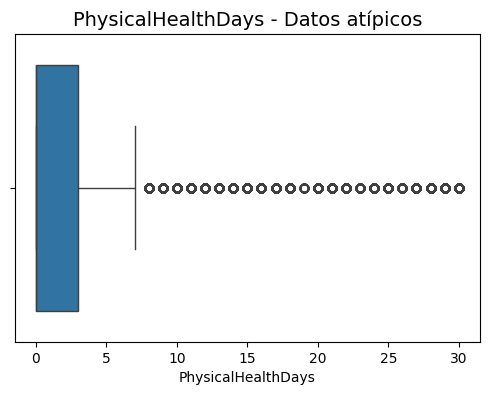

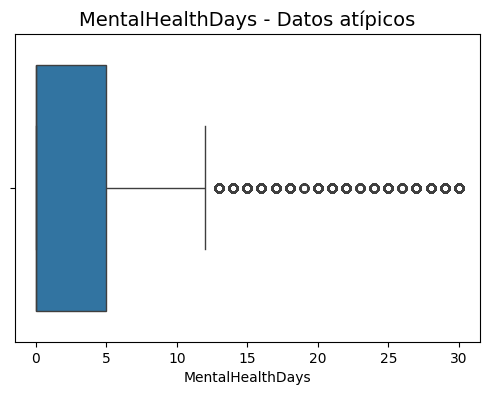

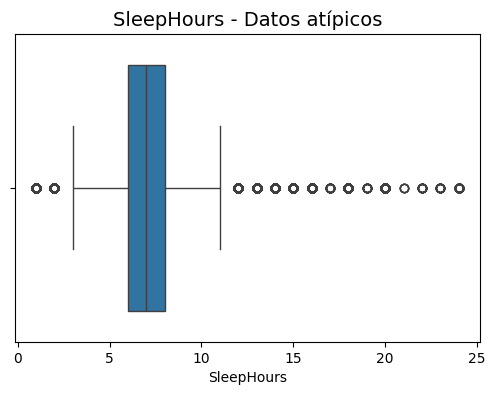

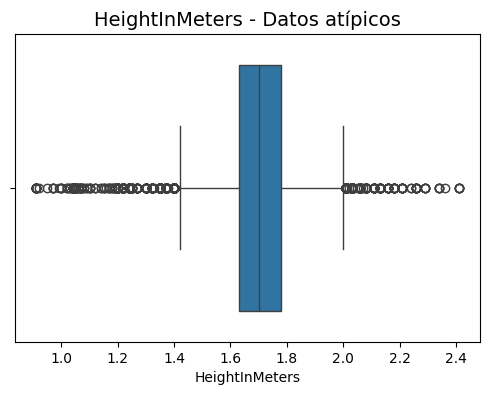

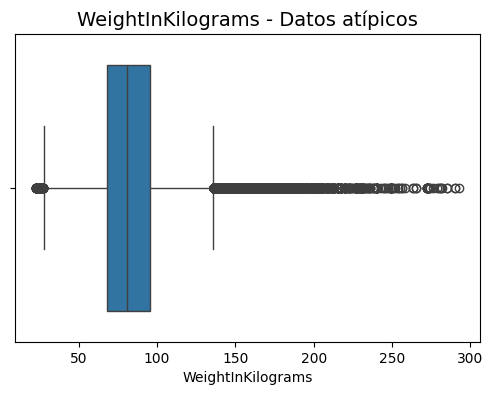

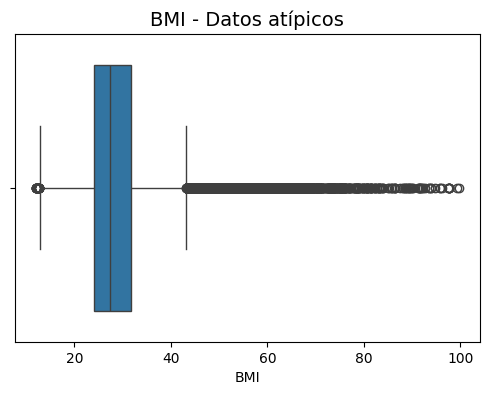

In [76]:


# Suponiendo que tienes tu DataFrame llamado 'df'
numerical_columns = [
    "PhysicalHealthDays", "MentalHealthDays", "SleepHours",
    "HeightInMeters", "WeightInKilograms", "BMI"
]

# Crear boxplots para cada columna numérica
for col in numerical_columns:
    plt.figure(figsize=(6, 4))  # Tamaño del gráfico
    sns.boxplot(x=df[col])
    plt.title(f'{col} - Datos atípicos', fontsize=14)
    plt.xlabel(col)
    plt.savefig(f"{col}_boxplot.png")  # Guarda la imagen
    plt.show()







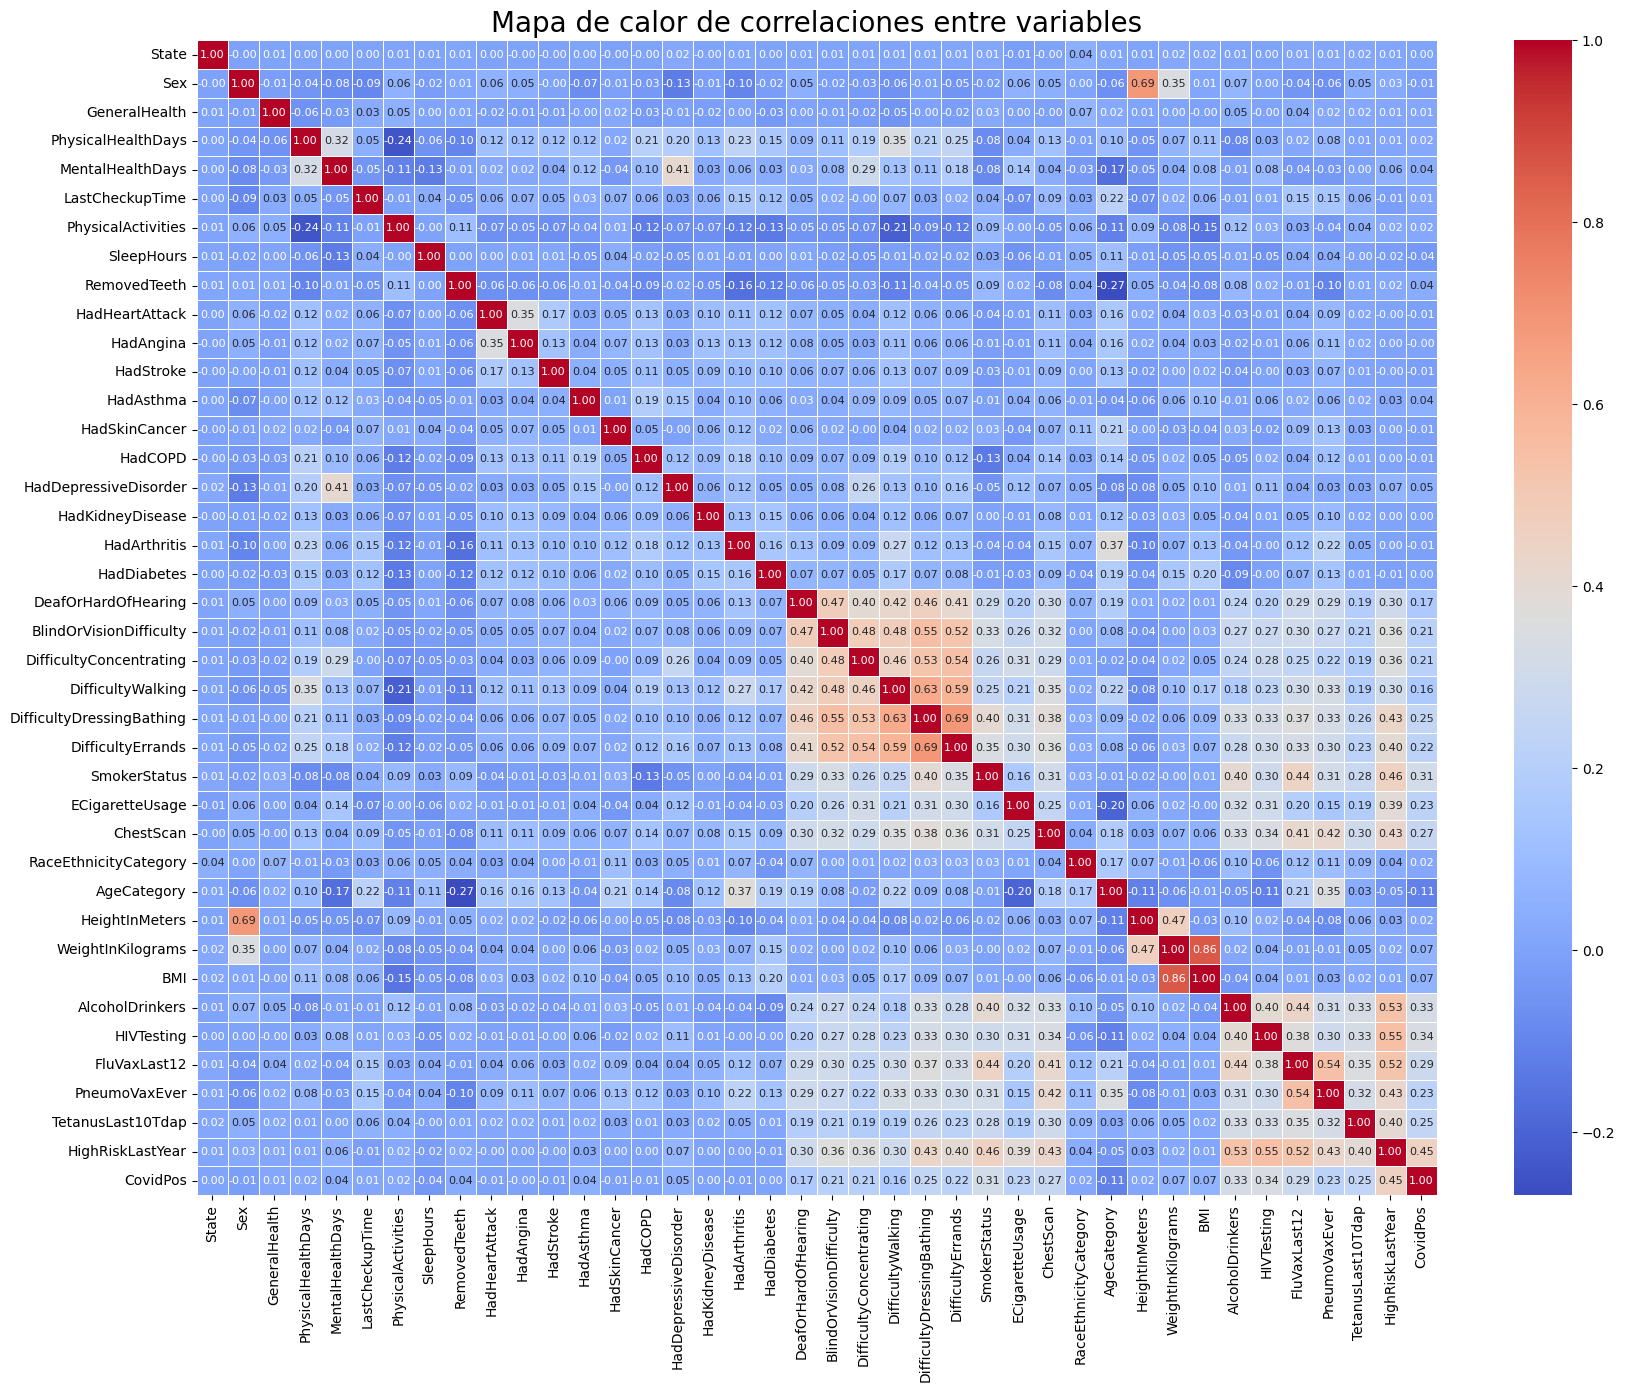

In [77]:


# Convertir variables categóricas a numéricas usando codificación ordinal
df_encoded = df.copy()

categorical_columns = [
    "State", "Sex", "GeneralHealth", "LastCheckupTime", "PhysicalActivities",
    "RemovedTeeth", "HadHeartAttack", "HadAngina", "HadStroke", "HadAsthma",
    "HadSkinCancer", "HadCOPD", "HadDepressiveDisorder", "HadKidneyDisease",
    "HadArthritis", "HadDiabetes", "DeafOrHardOfHearing", "BlindOrVisionDifficulty",
    "DifficultyConcentrating", "DifficultyWalking", "DifficultyDressingBathing",
    "DifficultyErrands", "SmokerStatus", "ECigaretteUsage", "ChestScan",
    "RaceEthnicityCategory", "AgeCategory", "AlcoholDrinkers", "HIVTesting",
    "FluVaxLast12", "PneumoVaxEver", "TetanusLast10Tdap", "HighRiskLastYear", "CovidPos"
]

for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes  # Asigna códigos numéricos a las categorías

# Calcular la matriz de correlación
corr_matrix = df_encoded.corr()

# Crear el heatmap con valores numéricos visibles y mayor tamaño
plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8}  # Reduce el tamaño de los números
)

# Configurar etiquetas
plt.xticks(rotation=90)  # Rotar etiquetas del eje X para mejor visualización
plt.yticks(rotation=0)   # Mantener las etiquetas del eje Y horizontales
plt.title("Mapa de calor de correlaciones entre variables", fontsize=20)

# Mostrar el heatmap
plt.show()



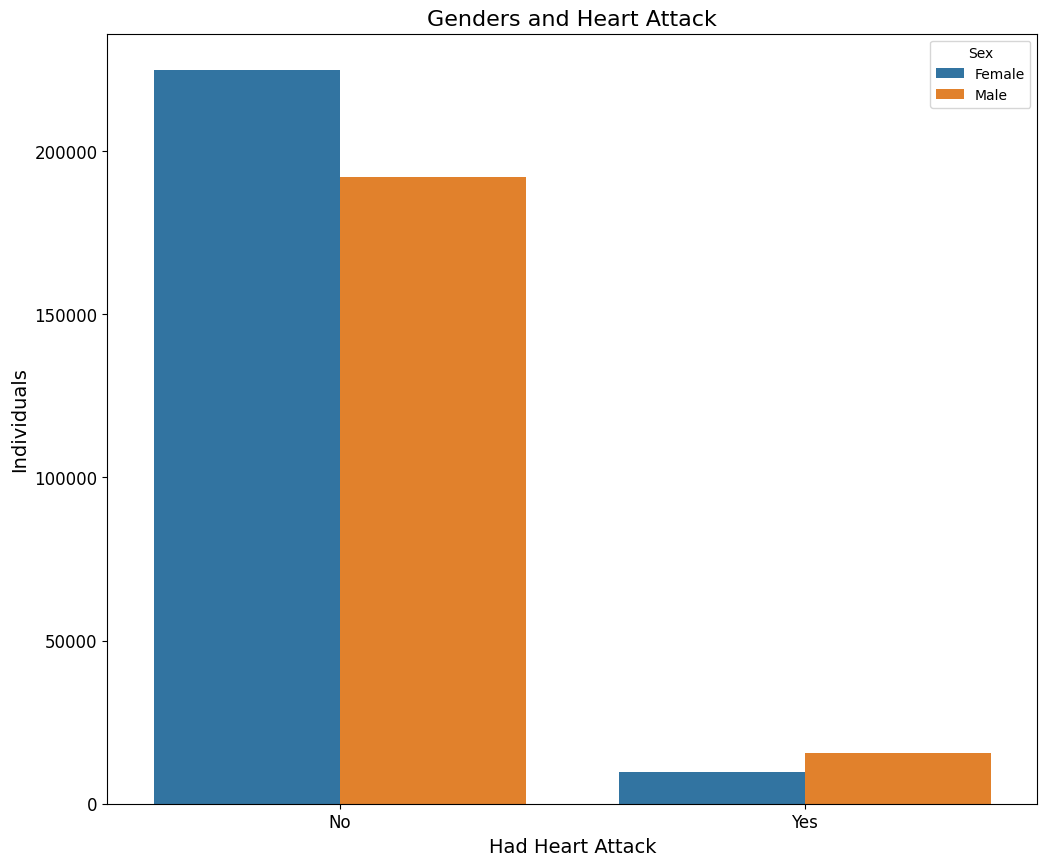

In [78]:
# Crear el gráfico de conteo con df_imputado
ax = sns.countplot(data=df, x='HadHeartAttack', hue='Sex')

# Función para personalizar el gráfico
def customize_plot(ax, title, xlabel, ylabel, width, height):
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gcf().set_size_inches(width, height)  # Ajustar tamaño de la figura

# Aplicar la personalización
customize_plot(ax, "Genders and Heart Attack", "Had Heart Attack", "Individuals", 12, 10)

# Guardar el gráfico en un archivo
scatter_fig = ax.get_figure()
scatter_fig.savefig('genderHeartAttack.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

<ipython-input-79-41725a08fc4c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


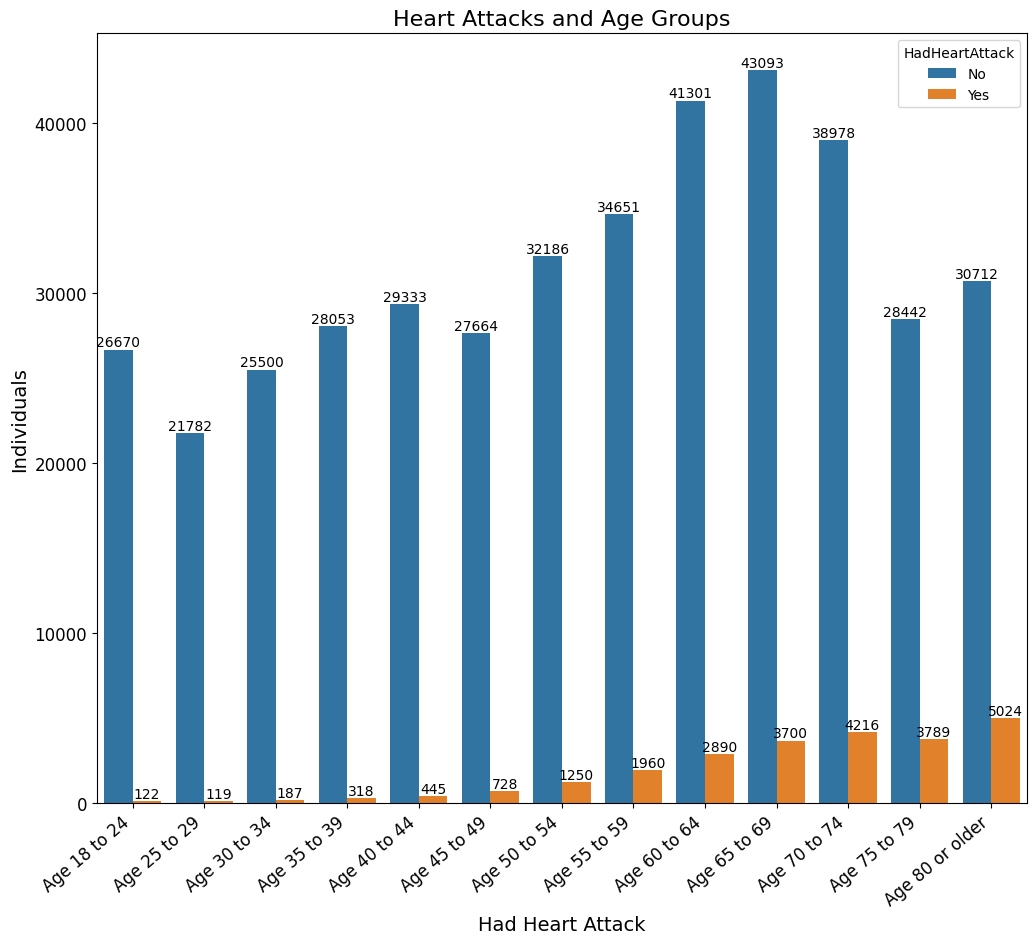

In [79]:
# Asegúrate de que 'AgeCategory' sea una columna categórica
df['AgeCategory'] = df['AgeCategory'].astype('category')

# Crear el gráfico de barras
ax = sns.countplot(data=df, x='AgeCategory', hue='HadHeartAttack')

# Rotar etiquetas del eje X para mejorar legibilidad
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Personalizar el gráfico
customize_plot(ax, "Heart Attacks and Age Groups", "Had Heart Attack", "Individuals", 12, 10)

# Añadir etiquetas a las barras
for c in ax.containers:
    ax.bar_label(c)

# Guardar el gráfico
scatter_fig = ax.get_figure()
scatter_fig.savefig('countplotByAge.png')

# Mostrar el gráfico
plt.show()

<ipython-input-80-f031522ac34a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


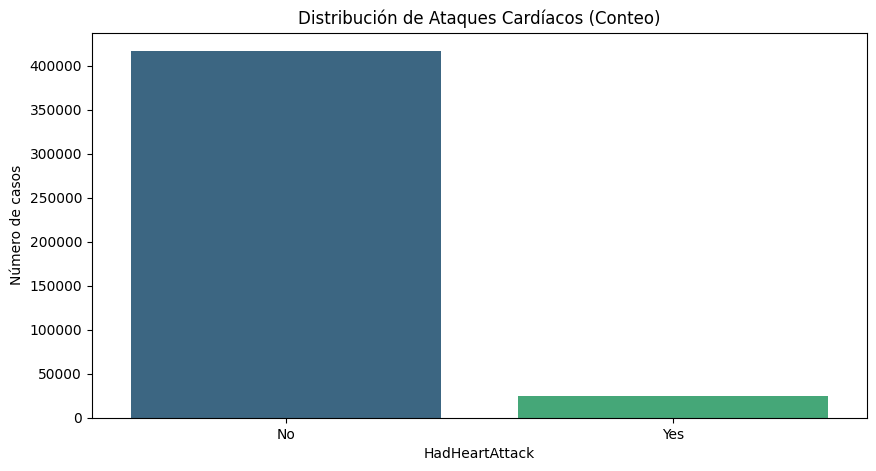

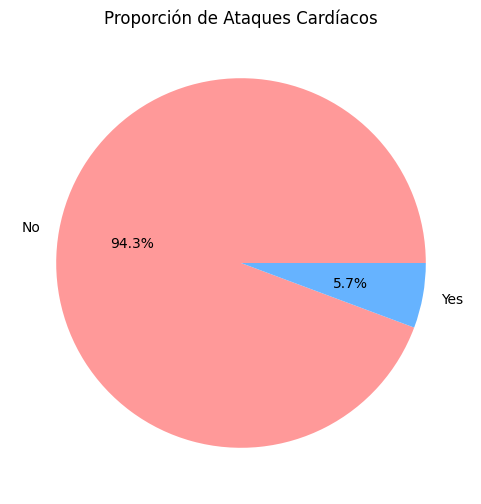

In [80]:

# 1. Conteo de clases
class_counts = df['HadHeartAttack'].value_counts()

# 2. Gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribución de Ataques Cardíacos (Conteo)")
plt.xlabel("HadHeartAttack")
plt.ylabel("Número de casos")
plt.show()

# 3. Gráfico de pastel (porcentajes)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Proporción de Ataques Cardíacos")
plt.show()

#**3) Limpieza de los Datasets**



**Limpieza de Dataset por Eliminación**



In [81]:
df_cleaned = df.dropna()  # Elimina filas con valores nulos
print(f"Filas originales: {df.shape[0]}")
print(f"Filas después de limpieza: {df_cleaned.shape[0]}")



Filas originales: 444975
Filas después de limpieza: 246013


**Limpieza de Dataset Usando Moda, Mediana**

In [82]:



df_imputado = df.copy()

# Identificar variables categóricas y numéricas
categorical_vars = df_imputado.select_dtypes(include=['object']).columns
binary_vars = [var for var in categorical_vars if df_imputado[var].nunique() == 2]  # Variables binarias
num_vars = df_imputado.select_dtypes(include=['float64']).columns

# Imputación con moda para categóricas y binarias
imputer_moda = SimpleImputer(strategy="most_frequent")
df_imputado[categorical_vars] = imputer_moda.fit_transform(df_imputado[categorical_vars])

# Imputación con mediana para variables numéricas
imputer_mediana = SimpleImputer(strategy="median")
df_imputado[num_vars] = imputer_mediana.fit_transform(df_imputado[num_vars])

# Guardar dataset imputado
df_imputado.to_csv("dataset_imputado.csv", index=False)




In [83]:
print(f"Filas originales: {df.shape[0]}")
print(f"Filas después de imputar: {df_imputado.shape[0]}")

Filas originales: 444975
Filas después de imputar: 444975


**Limpieza del Dataset por Imputación y eliminación condicional**

Durante el análisis exploratorio, identificamos una distribución significativamente desbalanceada en nuestro dataset: solo el 6% de los registros correspondían a casos positivos de ataques cardíacos ("HadHeartAttack = Yes"). Para optimizar la calidad de los datos y mejorar el aprendizaje del modelo sobre la clase minoritaria, implementamos la siguiente estrategia:

**Preservación de Casos Positivos:**

Todos los registros con ataques cardíacos confirmados se mantuvieron intactos, independientemente de valores faltantes.

Los valores nulos en estos casos positivos se imputaron usando la mediana (variables numéricas) y la moda (variables categóricas).

**Filtrado de Casos Negativos:**

Eliminamos registros incompletos donde "HadHeartAttack = No" para garantizar datos de alta calidad en la clase mayoritaria.

Esto aumentó proporcionalmente la representación de casos positivos en el dataset final.

<br>

**Resumen:** Randont Forest Pero con las Filas que tenian valores nulos eliminadas en "HadHearAttack = No" e imputados en HadHearAttack =SI"

In [84]:


# 1. Crear copia del dataframe original
df= df.copy()

# 2. Separar los casos positivos (Yes) y negativos (No)
positivos = df[df['HadHeartAttack'] == 'Yes']
negativos = df[df['HadHeartAttack'] == 'No']

# 3. Eliminar filas con valores nulos SOLO en los negativos (No)
negativos_limpios = negativos.dropna()

# 4. Combinar los positivos completos con los negativos limpios
df_Prueba = pd.concat([positivos, negativos_limpios], axis=0)

# 5. Imputación simple para las variables numéricas y categóricas restantes
# Seleccionar columnas numéricas y categóricas
numeric_cols = df_Prueba.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_Prueba.select_dtypes(include=['object', 'category']).columns

# Imputar numéricos con la mediana (menos sensible a outliers)
imputer_num = SimpleImputer(strategy='median')
df_Prueba[numeric_cols] = imputer_num.fit_transform(df_Prueba[numeric_cols])

# Imputar categóricas con la moda (valor más frecuente)
imputer_cat = SimpleImputer(strategy='most_frequent')
df_Prueba[categorical_cols] = imputer_cat.fit_transform(df_Prueba[categorical_cols])

# Verificación final
print(f"Registros originales: {len(df_Prueba)}")
print(f"Registros después del procesamiento: {len(df_Prueba)}")
print(f"Distribución de clases:\n{df_Prueba['HadHeartAttack'].value_counts(normalize=True)}")

Registros originales: 257686
Registros después del procesamiento: 257686
Distribución de clases:
HadHeartAttack
No     0.902564
Yes    0.097436
Name: proportion, dtype: float64


<ipython-input-85-f25e7aa3f912>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


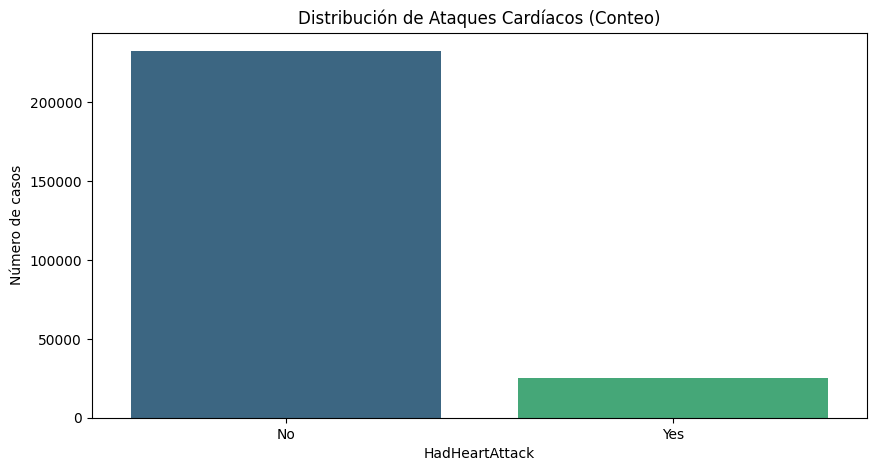

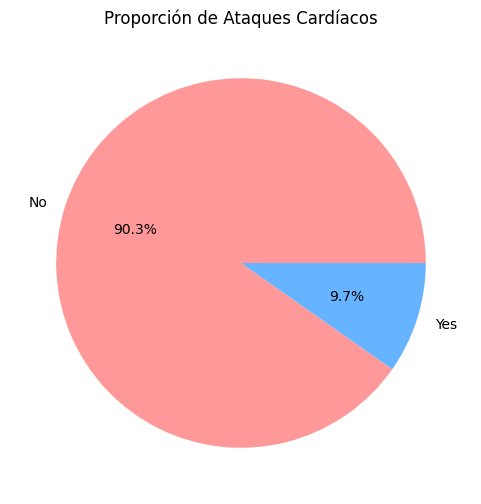

In [85]:


# 1. Conteo de clases
class_counts = df_Prueba['HadHeartAttack'].value_counts()

# 2. Gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribución de Ataques Cardíacos (Conteo)")
plt.xlabel("HadHeartAttack")
plt.ylabel("Número de casos")
plt.show()

# 3. Gráfico de pastel (porcentajes)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Proporción de Ataques Cardíacos")
plt.show()

# **4) Comparación de columnas numéricas del dataset original, eliminación de datos nulos e imputación.**

**Dataset con datos Originales**

In [86]:

df.describe()


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434053.000000,435913.000000,439527.000000,416470.000000,403044.000000,396316.000000
mean,4.349372,4.384164,7.022909,1.702690,83.074632,28.529907
std,8.689968,8.388541,1.502618,0.107178,21.448241,6.554917
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


**Dataset con datos nulos eliminados**

In [87]:
df_cleaned.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246013.000000,246013.000000,246013.000000,246013.000000,246013.000000,246013.000000
mean,4.119055,4.167292,7.021312,1.705150,83.615522,28.668258
std,8.405803,8.102796,1.440698,0.106654,21.323232,6.514005
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


**Dataset con datos Imputados**

In [88]:

df_imputado.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,444975.000000,444975.000000,444975.000000,444975.000000,444975.000000,444975.000000
mean,4.242616,4.294879,7.022628,1.702518,82.854634,28.410723
std,8.609002,8.325745,1.493393,0.103690,20.424073,6.195490
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.410000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,4.000000,8.000000,1.780000,91.630000,31.010000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


**Dataset por Imputación y eliminación condicional**

In [89]:
df_Prueba.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,257686.000000,257686.000000,257686.000000,257686.000000,257686.000000,257686.000000
mean,4.354691,4.226609,7.022570,1.705232,83.666623,28.673917
std,8.684627,8.202662,1.470295,0.106533,21.292551,6.498782
min,0.000000,0.000000,1.000000,0.910000,24.490000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.300000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


# **Análisis Comparativo de Métodos para el Manejo de Datos Faltantes**

Durante el análisis inicial, se detectó un fuerte desbalance en la variable objetivo: únicamente el 6% de los registros correspondían a pacientes que habían sufrido un ataque cardíaco (HadHeartAttack = Yes). Esta asimetría suponía un riesgo importante de que los modelos de clasificación aprendieran de forma sesgada, priorizando la clase mayoritaria (No), y comprometiendo la capacidad predictiva sobre los casos críticos (la clase minoritaria Yes).

# **✅ Estrategia Adoptada**
Para mejorar la representatividad de la clase minoritaria sin recurrir a técnicas sintéticas (como SMOTE) ni a un submuestreo agresivo de la clase mayoritaria, se adoptó la siguiente política de limpieza:

<br>

**Preservación de Casos Positivos (HadHeartAttack = Yes):**

Se conservaron todos los registros, independientemente de si contenían valores nulos.

Los valores faltantes en estos registros fueron imputados usando la mediana para variables numéricas y la moda para variables categóricas.

Esta imputación se justificó ya que el número de datos faltantes por variable era bajo, y el impacto estadístico de usar medidas de tendencia central era mínimo frente al beneficio de mantener estos casos clave.

<br>

**Filtrado de Casos Negativos (HadHeartAttack = No):**

Los registros incompletos de esta clase se eliminaron.

Dado que la clase mayoritaria estaba sobrerrepresentada, se consideró que eliminar estos registros no comprometería la capacidad del modelo para aprender correctamente su comportamiento.

Esta acción también contribuyó a mejorar ligeramente el balance del dataset.

# **🔍 Justificación Técnica y Ética**
El objetivo principal fue maximizar el aprendizaje de la clase positiva (ataques cardíacos), priorizando la retención de todos los datos disponibles en esa clase.

A nivel estadístico, los valores imputados no distorsionaron significativamente las distribuciones originales, dado que se utilizaron métodos robustos y no se observó un cambio sustancial en la media ni varianza de las variables afectadas.

Esta metodología favorece una mejor generalización del modelo sobre eventos raros y clínicamente relevantes, sin introducir sesgos artificiales ni perder información crítica.

# **📊 Resultado**
La aplicación de esta metodología permitió:

Mantener un conjunto de entrenamiento representativo y robusto.

Mejorar las métricas de rendimiento sobre la clase positiva (especialmente Recall y F1 Score).

Evitar tanto la sobreimputación como la pérdida innecesaria de datos relevantes.

# **5) Selección de atributos relevantes para la predicción de ataques cardíacos**


In [91]:
columnas_a_eliminar = [
    # variable objectivo. así que no debe estar en x para predecirla así misma
    'HadHeartAttack',
    'State',  # Ubicación geográfica no es un factor médico directo
    'DeafOrHardOfHearing',  # Problemas auditivos no relacionados
    'BlindOrVisionDifficulty',  # Problemas visuales no relacionados
    'HIVTesting',  # No directamente relacionado con salud cardíaca
    'RemovedTeeth',  # Salud dental no es predictor cardíaco
    'ChestScan',  # Es un examen, no un factor de riesgo
    'FluVaxLast12',  # Vacuna de gripe no es relevante
    'PneumoVaxEver',  # Vacuna neumococo no es relevante
    'CovidPos',  # Muy reciente para tener datos concluyentes
    'HeightInMeters',  # Mejor usar BMI que combina altura/peso
    'WeightInKilograms',  # Mejor usar BMI
    'DifficultyConcentrating',  # Síntoma muy genérico
    'DifficultyDressingBathing',  # Movilidad no específica cardíaca
    'DifficultyErrands'  # Movilidad no específica cardíaca
]


variables_clave = [


    # Factores demográficos básicos
    'Sex',
    'AgeCategory',

    # Salud general
    'GeneralHealth',
    'PhysicalHealthDays',
    'MentalHealthDays',
    'BMI',

    # Factores de riesgo cardiovascular
    'HadAngina',
    'HadStroke',
    'HadAsthma',
    'HadCOPD',
    'HadDiabetes',
    'HadKidneyDisease',
    'HadArthritis',

    # Hábitos de vida
    'SmokerStatus',
    'ECigaretteUsage',
    'AlcoholDrinkers',
    'PhysicalActivities',
    'SleepHours',

    # Comorbilidades relevantes
    'HadDepressiveDisorder',
    'HadSkinCancer',  # Algunos estudios muestran correlación

    # Exámenes médicos
    'LastCheckupTime',
    'HighRiskLastYear',

    # Dificultades físicas relacionadas
    'DifficultyWalking'  # Puede indicar problemas circulatorios
]

# **6) Primer Modelo de Maching Learning // Gradient-based One-Side Sampling**


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 17576, number of negative: 162804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

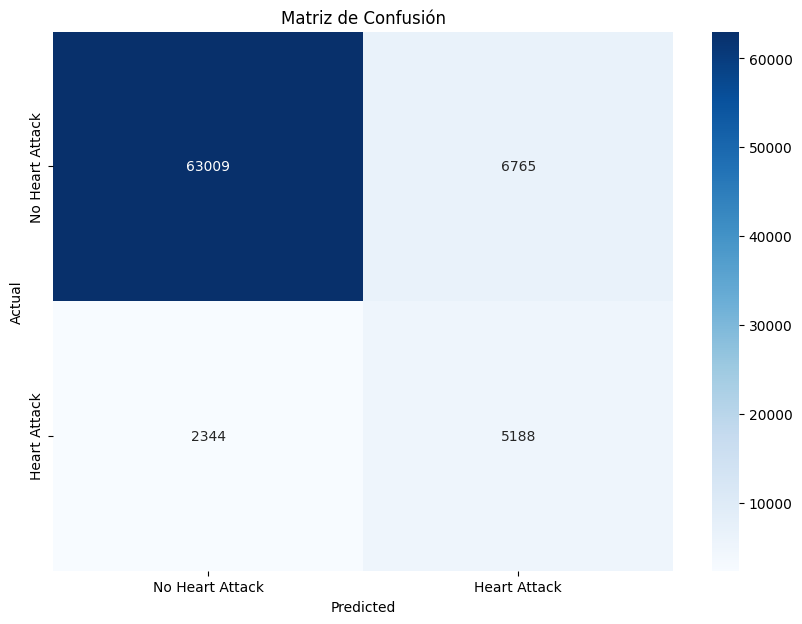

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


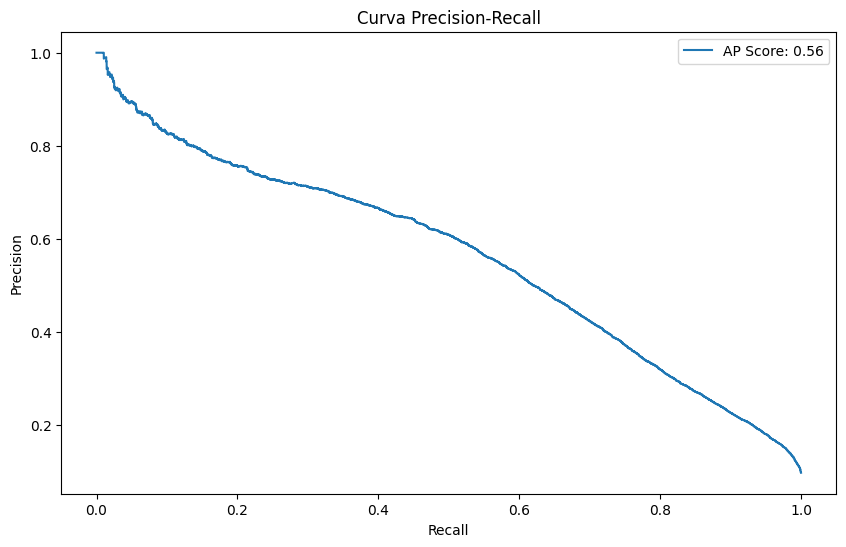

In [94]:


# 1. Preparación de Datos
# --------------------------------------------------
target_column = "HadHeartAttack"

# Convertir la variable objetivo a categórica directamente
df_Prueba[target_column] = df_Prueba[target_column].astype('category')

# Definir variables predictoras (X) y la variable objetivo (y)
X = df_Prueba.drop(columns=columnas_a_eliminar)  # Elimina todo de una vez
y = df_Prueba[target_column]  # Mantenemos como categoría

# Identificar columnas categóricas en X
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_columns] = X[categorical_columns].astype('category')

# 2. División de Datos
# --------------------------------------------------
# Dividir manteniendo las categorías originales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=87, stratify=y
)

# 3. Configuración y Entrenamiento del Modelo
# --------------------------------------------------
lgb_model = lgb.LGBMClassifier(
    boosting_type='goss',  # Gradient-based One-Side Sampling
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=15,
    num_leaves=31,
    min_child_samples=50,
    reg_alpha=0.5,
    reg_lambda=0.5,
    class_weight={'No': 1, 'Yes': 5},
    random_state=42,
    objective='binary',
    metric='aucpr',
    n_jobs=-1,
    importance_type='gain',
    min_data_in_leaf=100,
    cat_smooth=20,
    extra_trees=True
)

# Entrenamiento con early stopping (una sola vez)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    categorical_feature=categorical_columns,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# 4. Predicción y Evaluación
# --------------------------------------------------
# Realizar predicciones (ya están en las categorías originales)
y_pred = lgb_model.predict(X_test)

# Calcular métricas directamente con las categorías
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

# Imprimir métricas
print("\nMétricas de Evaluación:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Visualización
# --------------------------------------------------
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Heart Attack', 'Heart Attack'],
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva Precision-Recall (Opcional)

y_probs = lgb_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs, pos_label='Yes')
ap_score = average_precision_score(y_test, y_probs, pos_label='Yes')

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AP Score: {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

**Con todos el dataset**:

In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444975 entries, 0 to 445131
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Sex                    444975 non-null  category
 1   GeneralHealth          444975 non-null  category
 2   PhysicalHealthDays     444975 non-null  float64 
 3   MentalHealthDays       444975 non-null  float64 
 4   LastCheckupTime        444975 non-null  category
 5   PhysicalActivities     444975 non-null  category
 6   SleepHours             444975 non-null  float64 
 7   HadAngina              444975 non-null  category
 8   HadStroke              444975 non-null  category
 9   HadAsthma              444975 non-null  category
 10  HadSkinCancer          444975 non-null  category
 11  HadCOPD                444975 non-null  category
 12  HadDepressiveDisorder  444975 non-null  category
 13  HadKidneyDisease       444975 non-null  category
 14  HadArthritis           44

# **7) Segundo Modelo de Maching Learning // Random Forest**

[LightGBM] [Info] Number of positive: 17576, number of negative: 162804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 180380, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350561 -> initscore=-0.616575
[LightGBM] [Info] Start training from score -0.616575

Métricas de Evaluación:
Accuracy: 0.8826740485861382
Precision: 0.4328970331588133
Recall: 0.658656399362719
F1 Score: 0.5224304970513901


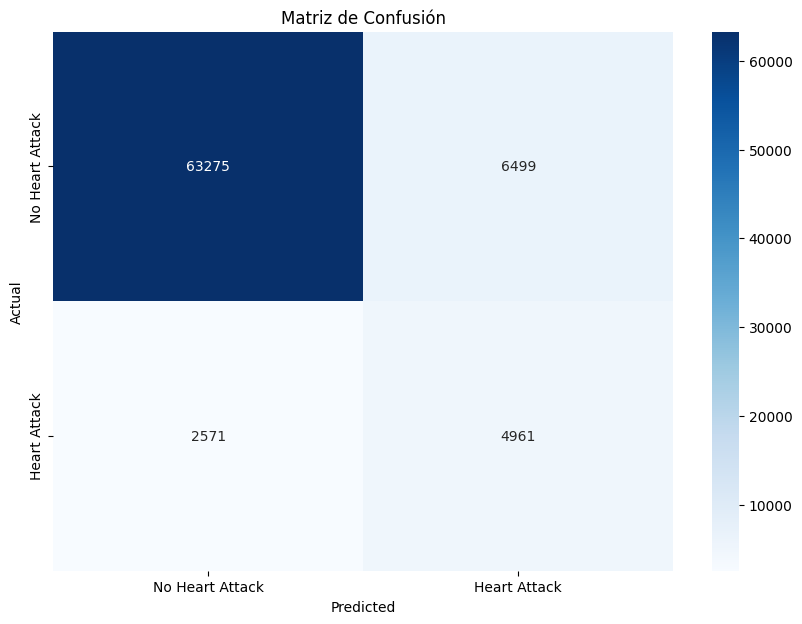

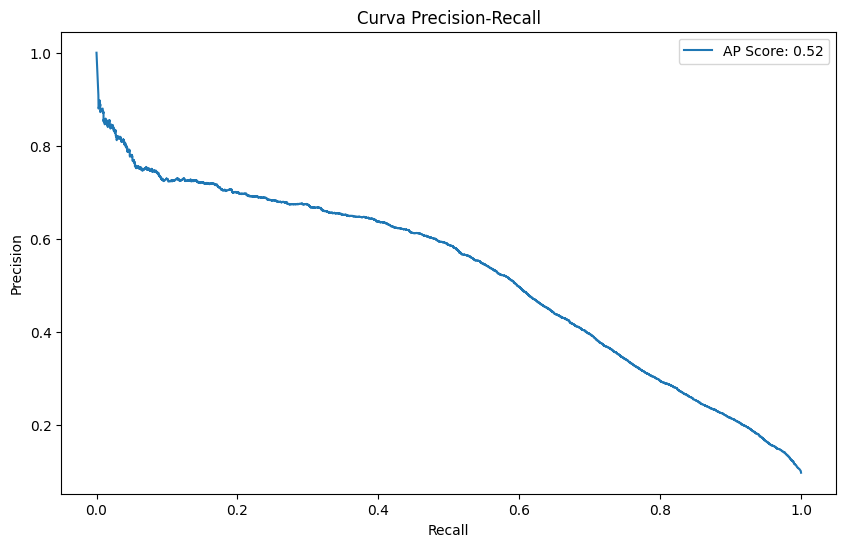

In [95]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación de Datos
# --------------------------------------------------
target_column = "HadHeartAttack"

# Convertir la variable objetivo a categórica directamente
df_Prueba[target_column] = df_Prueba[target_column].astype('category')

# Definir variables predictoras (X) y la variable objetivo (y)
X = df_Prueba.drop(columns=columnas_a_eliminar)  # Elimina todo de una vez
y = df_Prueba[target_column]  # Mantenemos como categoría

# Identificar columnas categóricas en X
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_columns] = X[categorical_columns].astype('category')

# 2. División de Datos
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=87, stratify=y
)

# 3. Configuración y Entrenamiento del Modelo
# --------------------------------------------------
lgb_model = lgb.LGBMClassifier(
    boosting_type='rf',  # ✅ Aquí usamos Random Forest
    n_estimators=1000,
    subsample=0.8,              # Muy importante en RF (bootstrap sample)
    subsample_freq=1,           # Usar subsample en cada iteración
    colsample_bytree=0.8,       # Selección aleatoria de features
    learning_rate=0.1,          # No debe ser muy bajo en RF
    max_depth=15,
    num_leaves=31,
    min_child_samples=50,
    reg_alpha=0.5,
    reg_lambda=0.5,
    class_weight={'No': 1, 'Yes': 5},
    random_state=42,
    objective='binary',
    metric='aucpr',
    n_jobs=-1,
    importance_type='gain',
    cat_smooth=20
)

# Entrenamiento (sin early stopping, ya que en Random Forest no tiene sentido)
lgb_model.fit(
    X_train, y_train,
    categorical_feature=categorical_columns
)

# 4. Predicción y Evaluación
# --------------------------------------------------
y_pred = lgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print("\nMétricas de Evaluación:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Visualización
# --------------------------------------------------
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Heart Attack', 'Heart Attack'],
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva Precision-Recall
y_probs = lgb_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs, pos_label='Yes')
ap_score = average_precision_score(y_test, y_probs, pos_label='Yes')

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AP Score: {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()


# **Dudas estrategicas 1 :**
1) ¿Dejamos el arbol así, con este rendimientos y prosigo con lo siguiente? si debemos avanzar y si al final hay tiempo mejorar algún que otro detalle

2) ¿Cómo justifico de que pensamos que seria mejor imputar los datos que eliminarlos pero resulto mejor combinar, imputando los que en HadHeartAttack = yes y HadHeartAttack = No? Historia de inicio a fin de las decisiones que tomamos.

3) ¿qué areas de mejoras propone y si vamos bien con el tiempo?tiempo bien con el tiempo y el profesor comenta de que se deben de meter más en el asunto Nathalia y Juan


# **Dudas estrategicas 2 :**

4) análisis con la data con el original pero con los datos vacios o nulos?

5) anova variable con diferentes relevancias para ver si vale la pena usarlas y no

6) Hago lo de Tablou primero o lo del LM, juntos con predecir una fila de información.